# Problem: Train an Autoencoder for Anomaly Detection

### Problem Statement
You are tasked with implementing an **autoencoder** model for anomaly detection. The model will be trained on the **MNIST dataset**, and anomalies will be detected based on the reconstruction error. The autoencoder consists of an encoder to compress the input and a decoder to reconstruct the image. The difference between the original image and the reconstructed image will be used to detect anomalies.

你的任务是实现一个用于异常检测的**自动编码器**模型。该模型将在**MNIST**数据集上进行训练，并根据重建误差检测异常。该自动编码器由一个用于压缩输入的编码器和一个用于重建图像的解码器组成。原始图像和重建图像之间的差异将用于检测异常。

### Requirements
1. **Define the Autoencoder Architecture**:
   - **Encoder**:
     - Implement a series of convolutional layers followed by max-pooling layers.
     - The encoder should progressively reduce the spatial dimensions of the input image, capturing the most important features.
   - **Decoder**:
     - Implement a series of transposed convolutional layers (also known as deconvolutional layers) to upsample the compressed representation back to the original image size.
     - Use a **Sigmoid activation** function in the final layer to ensure that the output pixel values are between 0 and 1.

2. **Forward Pass**:
   - Implement the forward method where the input image is passed through the encoder to obtain a compressed representation, followed by passing it through the decoder to reconstruct the image.

3. **定义自动编码器架构**：
- **编码器**：
- 实现一系列卷积层，然后是最大池化层。
- 编码器应逐步降低输入图像的空间维度，以捕捉最重要的特征。
- **解码器**：
- 实现一系列转置卷积层（也称为反卷积层），将压缩表示上采样回原始图像大小。
- 在最后一层使用**Sigmoid 激活函数**，以确保输出像素值介于 0 和 1 之间。

4. **前向传播**：
- 实现前向传播方法，将输入图像通过编码器获得压缩表示，然后通过解码器重建图像。



### Constraints
- The autoencoder should work on the MNIST dataset, which consists of 28x28 grayscale images.
- Ensure that the output of the decoder matches the original image size.
- Use **Sigmoid activation** in the final layer to constrain the output pixel values between 0 and 1.


<details>
  <summary>💡 Hint</summary>
  Focus on the encoder to downsample the input and the decoder to upsample and reconstruct the image.
</details>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

100.0%
100.0%
100.0%
100.0%


In [ ]:
# Define an Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample to 14x14
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample to 7x7
        )
        # Decoder
        self.decoder = nn.Sequential(
            # 转置卷积实现上采样
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),  # To keep pixel values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Training loop
epochs = 10
for epoch in range(epochs):
    for images, _ in train_loader:
        # Forward pass
        reconstructed = model(images)
        loss = criterion(reconstructed, images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.9224
Epoch [2/10], Loss: 0.9234
Epoch [3/10], Loss: 0.9281
Epoch [4/10], Loss: 0.9225
Epoch [5/10], Loss: 0.9266
Epoch [6/10], Loss: 0.9240
Epoch [7/10], Loss: 0.9225
Epoch [8/10], Loss: 0.9276
Epoch [9/10], Loss: 0.9221
Epoch [10/10], Loss: 0.9246


In [7]:
# Detect anomalies using reconstruction error
threshold = 0.1  # Define a threshold for anomaly detection
model.eval()
anomalies = []
with torch.no_grad():
    for images, _ in test_loader:
        reconstructed = model(images)
        loss = criterion(reconstructed, images)
        
        # If reconstruction error exceeds the threshold, mark it as an anomaly
        if loss.item() > threshold:
            anomalies.append(images)

Anomaly image shape: torch.Size([28, 28])


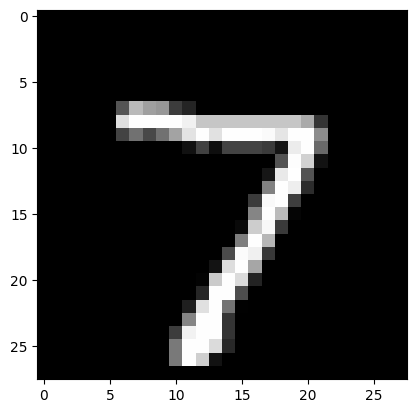

In [8]:
# Visualize anomalies
if anomalies:
    # Select the first anomaly and remove the channel dimension for visualization
    anomaly_image = anomalies[0][0].squeeze()  # Remove the channel dimension (1)
    print(f"Anomaly image shape: {anomaly_image.shape}")  # Optional: Check the shape of the image
    plt.imshow(anomaly_image.cpu().numpy(), cmap='gray')  # Convert tensor to NumPy array for visualization
    plt.show()
else:
    print("No anomalies detected.")
